# Checking GPU Situation:

In [2]:
!nvidia-smi

Sat Aug  9 10:59:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.62                 Driver Version: 572.62         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   39C    P0             11W /   35W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports:

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile as zipfile
from typing import Optional, Tuple
import time as time

# Extract File:

In [3]:
with zipfile.ZipFile('./CIRsV2.zip') as File:
    File.extract(member='features_IIoT_19.csv',path='./features_IIoT_19')

# 📁Pre_processing:

### Load Dataset:

In [4]:
df = pd.read_csv(r'.\features_IIoT_19\features_IIoT_19.csv')
df.head()

,fp_ampl1,fp_ampl2,fp_ampl3,std_noise,CIRpower,RXPACC,fpindex,RX_power,FP_power,Pd,Pr,estimated_range,distance_GT,error,label
0,1958,3287,3313,88,17640,1518,46350,-91.274,-111.719,20.445,1.223996,4485,4704.247761,219.247761,1
1,2098,3784,3740,96,20434,1517,47379,-91.918,-110.786,18.868,1.205270,4485,4704.247761,219.247761,1
2,1098,3806,2776,80,19063,1515,46442,-91.628,-111.343,19.715,1.215163,4490,4704.247761,214.247761,1
3,3404,2380,3918,84,18708,1518,46533,-91.529,-110.767,19.238,1.210185,4504,4704.247761,200.247761,1
4,1852,3659,2114,88,19107,1516,46779,-91.633,-112.927,21.294,1.232384,4527,4704.247761,177.247761,1


In [5]:
X = df.drop(columns=['distance_GT','error','label'])
X.shape

(17160, 12)

In [6]:
Y = df['label']
Y.shape

(17160,)

### Seperate Training and Validation and Testing from Main dataset:

In [7]:
x_train, x_rest, y_train, y_rest = train_test_split(X,Y,train_size=0.74592074592074592074592074592075,random_state=42,shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_rest,y_rest,test_size=0.205407925407925407925407925407925,shuffle=False)
print(f'x and y train are equal to {x_train.shape} and {y_train.shape} \nx and y test are equal to {x_test.shape} and {y_test.shape} \nx and y validation are equal to {x_valid.shape} and {y_valid.shape}')

x and y train are equal to (12800, 12) and (12800,) 
x and y test are equal to (896, 12) and (896,) 
x and y validation are equal to (3464, 12) and (3464,)


### Change to Tensor:

In [8]:
x_t = torch.FloatTensor(x_train.values)
y_t = torch.FloatTensor(y_train.values)
x_v = torch.FloatTensor(x_valid.values)
y_v = torch.FloatTensor(y_valid.values)
x_te = torch.FloatTensor(x_test.values)
y_te = torch.FloatTensor(y_test.values)

mu = x_t.mean(dim=0)
std = x_t.std(dim=0)

x_t = (x_t - mu) / std
x_v = (x_v - mu) / std
x_te = (x_te - mu) / std

### Data Loader:

In [9]:
train_dataset = TensorDataset(x_t,y_t)
valid_dataset = TensorDataset(x_v,y_v)
test_dataset = TensorDataset(x_te,y_te)

In [10]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle=False)
x_batch,y_batch = next(iter(train_loader))
x_batch.shape,y_batch.shape

(torch.Size([128, 12]), torch.Size([128]))

# 📁Model:

### Model Structue:

In [11]:
num_feats = 12
mum_class = 1

model = nn.Sequential(nn.Linear(num_feats,150),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.BatchNorm1d(150),
                      nn.Linear(150, 100),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(100, 50),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(50, 25),
                      nn.ReLU(),
                      nn.Linear(25, 1))

print([sum(p.numel() for p in model.parameters() if p.requires_grad)])
model(x_batch).shape

[23701]


torch.Size([128, 1])

### Loss and Optimizer:

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min')

# Device:

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Utiles:

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# 📁Functions:

In [15]:
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    loss_fn: nn.Module,
                    optimizer: optim,
                    device: str,
                    epoch: Optional[int] = None):
  """
  This function has been designed to train a Neural Network model for one epoch.

    Input Args that you must give it:
        model: PyTorch model to train.
        train_loader: DataLoader providing training data.
        loss_fn: Loss function to optimize.
        optimizer: Optimizer for parameter updates.
        device: Device to run training on ('cpu' or 'cuda').
        epoch: Optional epoch index for progress display.

    Returns:
        model: The trained model after this epoch.
        avg_loss: Average loss for the epoch.
        avg_accuracy: Average accuracy for the epoch (0-1 scale).
  """
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='binary').to(device)
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)
      # Forward pass
      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze() , targets)
      # Backward pass
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # Metrics update
      loss_train.update(loss.item())
      acc_train(outputs.squeeze(), targets.int())
      # Show progress
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [16]:
def evaluate(model: nn.Module, valid_loader: DataLoader, loss_fn: nn.Module):
  """
    Evaluates your PyTorch model on a validation dataset.

    Input Args that you must give it:
        model (nn.Module): The trained PyTorch model to evaluate.
        valid_loader (DataLoader): DataLoader providing validation data batches.
        loss_fn (nn.Module): Loss function used to compute validation loss.

    Returns Back:
        Tuple[float, float]: A tuple containing:
            - Average validation loss (float)
            - Validation accuracy (float), computed for a multiclass classification task with 10 classes.
  """
  model.eval()
  loss_valid = AverageMeter()
  acc_valid = Accuracy(task='binary').to(device)
  with torch.no_grad():
      for inputs, targets in valid_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss_valid.update(loss_fn(outputs.squeeze(), targets).item())
          acc_valid(outputs.squeeze(), targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# Train Loop:

In [17]:
num_epochs = 500
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []
lr_hist = []
best_loss_valid = torch.inf

In [18]:
begin = time.time()
for epoch in range(num_epochs):

    model, loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, device, epoch)
    loss_valid, acc_valid = evaluate(model, valid_loader, loss_fn)
    
    lr = optimizer.param_groups[0]['lr']
    scheduler.step(loss_valid)
      
    
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)
    
    lr_hist.append(lr)
    print(f'Valid: Loss={loss_valid:.4}, Accuracy={acc_valid:.4}\n')

    if loss_valid < best_loss_valid:
        torch.save(model, f'IOLAB19_DNN_Model.pt')
        best_loss_valid = loss_valid
        
end = time.time() 
elapsed_time = end - begin  
print(f"Execution Time: {elapsed_time/60}")

Epoch 0: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 28.40batch/s, accuracy=43.1, loss=0.664]


Valid: Loss=0.6387, Accuracy=0.2904



Epoch 1: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.60batch/s, accuracy=36.7, loss=0.621]


Valid: Loss=0.601, Accuracy=0.5788



Epoch 2: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 43.87batch/s, accuracy=71.1, loss=0.582]


Valid: Loss=0.5565, Accuracy=0.8274



Epoch 3: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.53batch/s, accuracy=70.7, loss=0.528]


Valid: Loss=0.4888, Accuracy=0.718



Epoch 4: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.84batch/s, accuracy=75.4, loss=0.451]


Valid: Loss=0.4047, Accuracy=0.8513



Epoch 5: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.08batch/s, accuracy=85.4, loss=0.369]


Valid: Loss=0.3357, Accuracy=0.873



Epoch 6: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 30.45batch/s, accuracy=88, loss=0.315]


Valid: Loss=0.3012, Accuracy=0.8736



Epoch 7: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.15batch/s, accuracy=87.9, loss=0.293]


Valid: Loss=0.2857, Accuracy=0.8773



Epoch 8: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 31.63batch/s, accuracy=88.9, loss=0.277]


Valid: Loss=0.2748, Accuracy=0.8822



Epoch 9: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 28.25batch/s, accuracy=88.9, loss=0.271]


Valid: Loss=0.2654, Accuracy=0.8868



Epoch 10: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.51batch/s, accuracy=89.6, loss=0.262]


Valid: Loss=0.2582, Accuracy=0.8926



Epoch 11: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.55batch/s, accuracy=90.1, loss=0.253]


Valid: Loss=0.2494, Accuracy=0.8978



Epoch 12: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 28.88batch/s, accuracy=90.3, loss=0.248]


Valid: Loss=0.2419, Accuracy=0.9024



Epoch 13: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.74batch/s, accuracy=90.5, loss=0.242]


Valid: Loss=0.2357, Accuracy=0.9065



Epoch 14: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.54batch/s, accuracy=90.9, loss=0.237]


Valid: Loss=0.2281, Accuracy=0.9114



Epoch 15: 100%|██████████████████████████████████████████| 100/100 [00:02<00:00, 33.91batch/s, accuracy=91, loss=0.231]


Valid: Loss=0.2229, Accuracy=0.914



Epoch 16: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.03batch/s, accuracy=91.4, loss=0.228]


Valid: Loss=0.2164, Accuracy=0.9169



Epoch 17: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 25.82batch/s, accuracy=91.6, loss=0.224]


Valid: Loss=0.212, Accuracy=0.9195



Epoch 18: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 28.36batch/s, accuracy=91.8, loss=0.219]


Valid: Loss=0.2085, Accuracy=0.9212



Epoch 19: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 27.34batch/s, accuracy=91.7, loss=0.218]


Valid: Loss=0.2029, Accuracy=0.9238



Epoch 20: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.88batch/s, accuracy=92.2, loss=0.21]


Valid: Loss=0.2017, Accuracy=0.9235



Epoch 21: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.56batch/s, accuracy=92.2, loss=0.208]


Valid: Loss=0.1974, Accuracy=0.9261



Epoch 22: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.34batch/s, accuracy=92.4, loss=0.205]


Valid: Loss=0.1947, Accuracy=0.9264



Epoch 23: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.62batch/s, accuracy=92.2, loss=0.205]


Valid: Loss=0.1904, Accuracy=0.929



Epoch 24: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.29batch/s, accuracy=92.5, loss=0.199]


Valid: Loss=0.1885, Accuracy=0.9278



Epoch 25: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.58batch/s, accuracy=92.4, loss=0.199]


Valid: Loss=0.1853, Accuracy=0.9324



Epoch 26: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.61batch/s, accuracy=92.7, loss=0.198]


Valid: Loss=0.1846, Accuracy=0.9284



Epoch 27: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.59batch/s, accuracy=92.8, loss=0.198]


Valid: Loss=0.1838, Accuracy=0.9278



Epoch 28: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.00batch/s, accuracy=92.8, loss=0.192]


Valid: Loss=0.1811, Accuracy=0.9293



Epoch 29: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.35batch/s, accuracy=92.7, loss=0.191]


Valid: Loss=0.1782, Accuracy=0.9333



Epoch 30: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.04batch/s, accuracy=93, loss=0.188]


Valid: Loss=0.1768, Accuracy=0.9353



Epoch 31: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.29batch/s, accuracy=93, loss=0.187]


Valid: Loss=0.176, Accuracy=0.9336



Epoch 32: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.74batch/s, accuracy=93, loss=0.183]


Valid: Loss=0.1742, Accuracy=0.9356



Epoch 33: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.63batch/s, accuracy=93.2, loss=0.185]


Valid: Loss=0.1734, Accuracy=0.9342



Epoch 34: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.99batch/s, accuracy=93.2, loss=0.181]


Valid: Loss=0.1708, Accuracy=0.9368



Epoch 35: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 28.48batch/s, accuracy=93.2, loss=0.178]


Valid: Loss=0.1703, Accuracy=0.9365



Epoch 36: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.47batch/s, accuracy=93.6, loss=0.176]


Valid: Loss=0.1689, Accuracy=0.9382



Epoch 37: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.53batch/s, accuracy=93.4, loss=0.179]


Valid: Loss=0.1677, Accuracy=0.9374



Epoch 38: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.58batch/s, accuracy=93.5, loss=0.175]


Valid: Loss=0.167, Accuracy=0.9374



Epoch 39: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.55batch/s, accuracy=93.6, loss=0.173]


Valid: Loss=0.1655, Accuracy=0.9397



Epoch 40: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.98batch/s, accuracy=93.5, loss=0.176]


Valid: Loss=0.1654, Accuracy=0.9382



Epoch 41: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.30batch/s, accuracy=93.6, loss=0.174]


Valid: Loss=0.1641, Accuracy=0.9402



Epoch 42: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.17batch/s, accuracy=93.6, loss=0.172]


Valid: Loss=0.1624, Accuracy=0.9417



Epoch 43: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.70batch/s, accuracy=93.5, loss=0.171]


Valid: Loss=0.1615, Accuracy=0.9411



Epoch 44: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.87batch/s, accuracy=93.8, loss=0.169]


Valid: Loss=0.162, Accuracy=0.9408



Epoch 45: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.65batch/s, accuracy=93.8, loss=0.17]


Valid: Loss=0.1592, Accuracy=0.9434



Epoch 46: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.91batch/s, accuracy=93.8, loss=0.17]


Valid: Loss=0.1588, Accuracy=0.9428



Epoch 47: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 31.12batch/s, accuracy=94, loss=0.167]


Valid: Loss=0.1577, Accuracy=0.944



Epoch 48: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.50batch/s, accuracy=93.9, loss=0.165]


Valid: Loss=0.1571, Accuracy=0.9449



Epoch 49: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.43batch/s, accuracy=93.8, loss=0.166]


Valid: Loss=0.1562, Accuracy=0.9443



Epoch 50: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.94batch/s, accuracy=93.8, loss=0.168]


Valid: Loss=0.1561, Accuracy=0.9434



Epoch 51: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.03batch/s, accuracy=93.9, loss=0.164]


Valid: Loss=0.1564, Accuracy=0.9431



Epoch 52: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.47batch/s, accuracy=94.1, loss=0.16]


Valid: Loss=0.1539, Accuracy=0.9443



Epoch 53: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.36batch/s, accuracy=94.1, loss=0.159]


Valid: Loss=0.1535, Accuracy=0.9454



Epoch 54: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 29.57batch/s, accuracy=94, loss=0.162]


Valid: Loss=0.1521, Accuracy=0.946



Epoch 55: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.67batch/s, accuracy=94.1, loss=0.16]


Valid: Loss=0.1518, Accuracy=0.9446



Epoch 56: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.65batch/s, accuracy=94.3, loss=0.16]


Valid: Loss=0.1517, Accuracy=0.944



Epoch 57: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.63batch/s, accuracy=94.2, loss=0.157]


Valid: Loss=0.1507, Accuracy=0.9457



Epoch 58: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.92batch/s, accuracy=94.2, loss=0.158]


Valid: Loss=0.1503, Accuracy=0.9463



Epoch 59: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.55batch/s, accuracy=94.2, loss=0.157]


Valid: Loss=0.1492, Accuracy=0.9466



Epoch 60: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.12batch/s, accuracy=94.3, loss=0.157]


Valid: Loss=0.1483, Accuracy=0.9472



Epoch 61: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 28.75batch/s, accuracy=94.2, loss=0.158]


Valid: Loss=0.1492, Accuracy=0.9469



Epoch 62: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.80batch/s, accuracy=94.3, loss=0.156]


Valid: Loss=0.1478, Accuracy=0.9475



Epoch 63: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.27batch/s, accuracy=94.3, loss=0.156]


Valid: Loss=0.1478, Accuracy=0.9472



Epoch 64: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.80batch/s, accuracy=94.4, loss=0.155]


Valid: Loss=0.1466, Accuracy=0.9475



Epoch 65: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.29batch/s, accuracy=94.4, loss=0.153]


Valid: Loss=0.1465, Accuracy=0.9472



Epoch 66: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.14batch/s, accuracy=94.5, loss=0.155]


Valid: Loss=0.146, Accuracy=0.9472



Epoch 67: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.28batch/s, accuracy=94.4, loss=0.153]


Valid: Loss=0.145, Accuracy=0.9475



Epoch 68: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.42batch/s, accuracy=94.4, loss=0.153]


Valid: Loss=0.1443, Accuracy=0.9492



Epoch 69: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.03batch/s, accuracy=94.6, loss=0.151]


Valid: Loss=0.1437, Accuracy=0.948



Epoch 70: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 29.73batch/s, accuracy=94.6, loss=0.151]


Valid: Loss=0.1438, Accuracy=0.9492



Epoch 71: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 30.87batch/s, accuracy=94.5, loss=0.152]


Valid: Loss=0.1438, Accuracy=0.9472



Epoch 72: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.55batch/s, accuracy=94.7, loss=0.15]


Valid: Loss=0.1436, Accuracy=0.9477



Epoch 73: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.30batch/s, accuracy=94.7, loss=0.146]


Valid: Loss=0.1426, Accuracy=0.9486



Epoch 74: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.38batch/s, accuracy=94.3, loss=0.152]


Valid: Loss=0.1417, Accuracy=0.948



Epoch 75: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.32batch/s, accuracy=94.8, loss=0.148]


Valid: Loss=0.1421, Accuracy=0.948



Epoch 76: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.67batch/s, accuracy=94.7, loss=0.148]


Valid: Loss=0.1405, Accuracy=0.9495



Epoch 77: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.71batch/s, accuracy=94.6, loss=0.146]


Valid: Loss=0.1405, Accuracy=0.9489



Epoch 78: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.42batch/s, accuracy=94.4, loss=0.15]


Valid: Loss=0.1398, Accuracy=0.9495



Epoch 79: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.35batch/s, accuracy=94.6, loss=0.145]


Valid: Loss=0.1397, Accuracy=0.9498



Epoch 80: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.58batch/s, accuracy=94.7, loss=0.144]


Valid: Loss=0.1388, Accuracy=0.9492



Epoch 81: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.92batch/s, accuracy=94.7, loss=0.143]


Valid: Loss=0.1395, Accuracy=0.9489



Epoch 82: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.44batch/s, accuracy=94.6, loss=0.146]


Valid: Loss=0.1391, Accuracy=0.9512



Epoch 83: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.16batch/s, accuracy=94.5, loss=0.145]


Valid: Loss=0.1367, Accuracy=0.9506



Epoch 84: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.95batch/s, accuracy=94.8, loss=0.142]


Valid: Loss=0.1367, Accuracy=0.9498



Epoch 85: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.00batch/s, accuracy=94.7, loss=0.143]


Valid: Loss=0.1361, Accuracy=0.9524



Epoch 86: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.87batch/s, accuracy=94.8, loss=0.141]


Valid: Loss=0.1368, Accuracy=0.9509



Epoch 87: 100%|██████████████████████████████████████████| 100/100 [00:02<00:00, 35.31batch/s, accuracy=95, loss=0.139]


Valid: Loss=0.1352, Accuracy=0.9515



Epoch 88: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.05batch/s, accuracy=94.8, loss=0.141]


Valid: Loss=0.1347, Accuracy=0.9521



Epoch 89: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.25batch/s, accuracy=94.8, loss=0.14]


Valid: Loss=0.1338, Accuracy=0.9503



Epoch 90: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.46batch/s, accuracy=95.1, loss=0.138]


Valid: Loss=0.1333, Accuracy=0.9512



Epoch 91: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.52batch/s, accuracy=94.8, loss=0.141]


Valid: Loss=0.1327, Accuracy=0.9518



Epoch 92: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.28batch/s, accuracy=95.1, loss=0.137]


Valid: Loss=0.1347, Accuracy=0.9501



Epoch 93: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.92batch/s, accuracy=94.9, loss=0.137]


Valid: Loss=0.1336, Accuracy=0.9512



Epoch 94: 100%|███████████████████████████████████████████| 100/100 [00:02<00:00, 35.70batch/s, accuracy=95, loss=0.14]


Valid: Loss=0.1314, Accuracy=0.9521



Epoch 95: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.52batch/s, accuracy=95.2, loss=0.134]


Valid: Loss=0.1311, Accuracy=0.9524



Epoch 96: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.56batch/s, accuracy=95.1, loss=0.135]


Valid: Loss=0.1331, Accuracy=0.9501



Epoch 97: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.69batch/s, accuracy=95.2, loss=0.133]


Valid: Loss=0.1318, Accuracy=0.9512



Epoch 98: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.91batch/s, accuracy=95.2, loss=0.134]


Valid: Loss=0.1308, Accuracy=0.9524



Epoch 99: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.77batch/s, accuracy=94.9, loss=0.139]


Valid: Loss=0.1353, Accuracy=0.9509



Epoch 100: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.76batch/s, accuracy=95.1, loss=0.135]


Valid: Loss=0.1295, Accuracy=0.9532



Epoch 101: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.97batch/s, accuracy=95.1, loss=0.134]


Valid: Loss=0.129, Accuracy=0.9535



Epoch 102: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.74batch/s, accuracy=95.1, loss=0.134]


Valid: Loss=0.1294, Accuracy=0.9529



Epoch 103: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.08batch/s, accuracy=95.1, loss=0.134]


Valid: Loss=0.1296, Accuracy=0.9529



Epoch 104: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.71batch/s, accuracy=95.2, loss=0.134]


Valid: Loss=0.1288, Accuracy=0.9524



Epoch 105: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.82batch/s, accuracy=95.2, loss=0.134]


Valid: Loss=0.1313, Accuracy=0.9509



Epoch 106: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.67batch/s, accuracy=95.2, loss=0.13]


Valid: Loss=0.128, Accuracy=0.9532



Epoch 107: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.55batch/s, accuracy=95.2, loss=0.135]


Valid: Loss=0.1276, Accuracy=0.9538



Epoch 108: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.68batch/s, accuracy=95.4, loss=0.129]


Valid: Loss=0.1278, Accuracy=0.9541



Epoch 109: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.30batch/s, accuracy=95.2, loss=0.131]


Valid: Loss=0.1267, Accuracy=0.9541



Epoch 110: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.78batch/s, accuracy=95.2, loss=0.134]


Valid: Loss=0.1282, Accuracy=0.9512



Epoch 111: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.29batch/s, accuracy=95.4, loss=0.129]


Valid: Loss=0.1259, Accuracy=0.955



Epoch 112: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.23batch/s, accuracy=95.5, loss=0.13]


Valid: Loss=0.1258, Accuracy=0.955



Epoch 113: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 33.06batch/s, accuracy=95.2, loss=0.133]


Valid: Loss=0.1249, Accuracy=0.955



Epoch 114: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.25batch/s, accuracy=95.3, loss=0.129]


Valid: Loss=0.1257, Accuracy=0.9541



Epoch 115: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.55batch/s, accuracy=95.4, loss=0.13]


Valid: Loss=0.1253, Accuracy=0.9555



Epoch 116: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.36batch/s, accuracy=95.6, loss=0.128]


Valid: Loss=0.1253, Accuracy=0.9564



Epoch 117: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.18batch/s, accuracy=95.7, loss=0.125]


Valid: Loss=0.1245, Accuracy=0.9561



Epoch 118: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.80batch/s, accuracy=95.4, loss=0.13]


Valid: Loss=0.1267, Accuracy=0.9544



Epoch 119: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 33.20batch/s, accuracy=95.5, loss=0.124]


Valid: Loss=0.1232, Accuracy=0.9567



Epoch 120: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.56batch/s, accuracy=95.6, loss=0.126]


Valid: Loss=0.1237, Accuracy=0.9581



Epoch 121: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.65batch/s, accuracy=95.6, loss=0.126]


Valid: Loss=0.1222, Accuracy=0.9587



Epoch 122: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 31.68batch/s, accuracy=95.3, loss=0.129]


Valid: Loss=0.1219, Accuracy=0.959



Epoch 123: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 33.28batch/s, accuracy=95.6, loss=0.123]


Valid: Loss=0.1207, Accuracy=0.9584



Epoch 124: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.54batch/s, accuracy=95.7, loss=0.124]


Valid: Loss=0.1204, Accuracy=0.9596



Epoch 125: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.32batch/s, accuracy=95.5, loss=0.128]


Valid: Loss=0.1209, Accuracy=0.9587



Epoch 126: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.05batch/s, accuracy=95.4, loss=0.126]


Valid: Loss=0.1204, Accuracy=0.959



Epoch 127: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.97batch/s, accuracy=95.5, loss=0.124]


Valid: Loss=0.1223, Accuracy=0.9596



Epoch 128: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.57batch/s, accuracy=95.5, loss=0.127]


Valid: Loss=0.1187, Accuracy=0.9599



Epoch 129: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.35batch/s, accuracy=95.8, loss=0.124]


Valid: Loss=0.12, Accuracy=0.9613



Epoch 130: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.07batch/s, accuracy=95.9, loss=0.119]


Valid: Loss=0.1176, Accuracy=0.9619



Epoch 131: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.37batch/s, accuracy=95.8, loss=0.122]


Valid: Loss=0.1185, Accuracy=0.9616



Epoch 132: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.98batch/s, accuracy=95.7, loss=0.121]


Valid: Loss=0.1178, Accuracy=0.9593



Epoch 133: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.53batch/s, accuracy=96, loss=0.119]


Valid: Loss=0.1176, Accuracy=0.9607



Epoch 134: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.17batch/s, accuracy=96, loss=0.117]


Valid: Loss=0.1173, Accuracy=0.9622



Epoch 135: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.18batch/s, accuracy=95.6, loss=0.119]


Valid: Loss=0.1175, Accuracy=0.9602



Epoch 136: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.51batch/s, accuracy=95.7, loss=0.121]


Valid: Loss=0.1153, Accuracy=0.9622



Epoch 137: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.73batch/s, accuracy=95.8, loss=0.12]


Valid: Loss=0.115, Accuracy=0.9628



Epoch 138: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.74batch/s, accuracy=95.9, loss=0.121]


Valid: Loss=0.117, Accuracy=0.9607



Epoch 139: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.90batch/s, accuracy=95.7, loss=0.118]


Valid: Loss=0.115, Accuracy=0.9619



Epoch 140: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 34.15batch/s, accuracy=96, loss=0.118]


Valid: Loss=0.115, Accuracy=0.9605



Epoch 141: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.42batch/s, accuracy=95.9, loss=0.121]


Valid: Loss=0.1153, Accuracy=0.9622



Epoch 142: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.52batch/s, accuracy=96, loss=0.117]


Valid: Loss=0.1146, Accuracy=0.9625



Epoch 143: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.33batch/s, accuracy=95.6, loss=0.122]


Valid: Loss=0.1136, Accuracy=0.9642



Epoch 144: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.11batch/s, accuracy=95.9, loss=0.117]


Valid: Loss=0.1153, Accuracy=0.9616



Epoch 145: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.73batch/s, accuracy=95.8, loss=0.119]


Valid: Loss=0.113, Accuracy=0.9633



Epoch 146: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.95batch/s, accuracy=95.9, loss=0.117]


Valid: Loss=0.1132, Accuracy=0.9633



Epoch 147: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.25batch/s, accuracy=96.1, loss=0.116]


Valid: Loss=0.112, Accuracy=0.9639



Epoch 148: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.96batch/s, accuracy=96, loss=0.116]


Valid: Loss=0.1119, Accuracy=0.9639



Epoch 149: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.59batch/s, accuracy=96.1, loss=0.119]


Valid: Loss=0.1129, Accuracy=0.9622



Epoch 150: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.52batch/s, accuracy=95.9, loss=0.118]


Valid: Loss=0.1118, Accuracy=0.9633



Epoch 151: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.40batch/s, accuracy=96.2, loss=0.115]


Valid: Loss=0.1118, Accuracy=0.9642



Epoch 152: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.28batch/s, accuracy=95.9, loss=0.114]


Valid: Loss=0.1127, Accuracy=0.9636



Epoch 153: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.62batch/s, accuracy=96.3, loss=0.113]


Valid: Loss=0.1108, Accuracy=0.9654



Epoch 154: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.11batch/s, accuracy=96.1, loss=0.111]


Valid: Loss=0.1099, Accuracy=0.9645



Epoch 155: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.09batch/s, accuracy=95.9, loss=0.118]


Valid: Loss=0.1091, Accuracy=0.9654



Epoch 156: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.11batch/s, accuracy=96.1, loss=0.114]


Valid: Loss=0.1096, Accuracy=0.9654



Epoch 157: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.73batch/s, accuracy=95.9, loss=0.116]


Valid: Loss=0.1116, Accuracy=0.9633



Epoch 158: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.73batch/s, accuracy=95.9, loss=0.116]


Valid: Loss=0.1086, Accuracy=0.9654



Epoch 159: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.71batch/s, accuracy=96.1, loss=0.113]


Valid: Loss=0.1086, Accuracy=0.9645



Epoch 160: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.90batch/s, accuracy=96.1, loss=0.113]


Valid: Loss=0.1095, Accuracy=0.9654



Epoch 161: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.29batch/s, accuracy=96.2, loss=0.113]


Valid: Loss=0.1076, Accuracy=0.9648



Epoch 162: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.01batch/s, accuracy=95.9, loss=0.116]


Valid: Loss=0.109, Accuracy=0.9648



Epoch 163: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.63batch/s, accuracy=96.1, loss=0.113]


Valid: Loss=0.108, Accuracy=0.9659



Epoch 164: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.01batch/s, accuracy=96.2, loss=0.111]


Valid: Loss=0.108, Accuracy=0.9659



Epoch 165: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.64batch/s, accuracy=96.1, loss=0.115]


Valid: Loss=0.1096, Accuracy=0.9651



Epoch 166: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.79batch/s, accuracy=96.1, loss=0.114]


Valid: Loss=0.108, Accuracy=0.9648



Epoch 167: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.03batch/s, accuracy=96.1, loss=0.112]


Valid: Loss=0.1082, Accuracy=0.9662



Epoch 168: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.69batch/s, accuracy=96.3, loss=0.109]


Valid: Loss=0.1076, Accuracy=0.9659



Epoch 169: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.03batch/s, accuracy=96.3, loss=0.109]


Valid: Loss=0.1074, Accuracy=0.9648



Epoch 170: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.62batch/s, accuracy=96.3, loss=0.11]


Valid: Loss=0.109, Accuracy=0.9656



Epoch 171: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.01batch/s, accuracy=96.3, loss=0.11]


Valid: Loss=0.107, Accuracy=0.9642



Epoch 172: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.26batch/s, accuracy=96.4, loss=0.11]


Valid: Loss=0.1068, Accuracy=0.9668



Epoch 173: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.19batch/s, accuracy=96.3, loss=0.11]


Valid: Loss=0.1075, Accuracy=0.9668



Epoch 174: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.11batch/s, accuracy=96.3, loss=0.11]


Valid: Loss=0.1059, Accuracy=0.9671



Epoch 175: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 33.05batch/s, accuracy=96.1, loss=0.109]


Valid: Loss=0.1049, Accuracy=0.9665



Epoch 176: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 31.91batch/s, accuracy=96, loss=0.111]


Valid: Loss=0.104, Accuracy=0.9668



Epoch 177: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.06batch/s, accuracy=96.2, loss=0.11]


Valid: Loss=0.105, Accuracy=0.9654



Epoch 178: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.25batch/s, accuracy=96.4, loss=0.106]


Valid: Loss=0.1036, Accuracy=0.9665



Epoch 179: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.05batch/s, accuracy=96.5, loss=0.106]


Valid: Loss=0.1044, Accuracy=0.9654



Epoch 180: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.48batch/s, accuracy=96.2, loss=0.108]


Valid: Loss=0.1027, Accuracy=0.968



Epoch 181: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.90batch/s, accuracy=96.2, loss=0.109]


Valid: Loss=0.1035, Accuracy=0.9677



Epoch 182: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.66batch/s, accuracy=96.3, loss=0.106]


Valid: Loss=0.105, Accuracy=0.9659



Epoch 183: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.45batch/s, accuracy=96.4, loss=0.106]


Valid: Loss=0.1028, Accuracy=0.9685



Epoch 184: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.88batch/s, accuracy=96.5, loss=0.108]


Valid: Loss=0.1042, Accuracy=0.9674



Epoch 185: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 39.92batch/s, accuracy=96.3, loss=0.107]


Valid: Loss=0.1017, Accuracy=0.9691



Epoch 186: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 109.89batch/s, accuracy=96.5, loss=0.105]


Valid: Loss=0.1024, Accuracy=0.9674



Epoch 187: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 85.63batch/s, accuracy=96.5, loss=0.103]


Valid: Loss=0.1028, Accuracy=0.9677



Epoch 188: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 31.81batch/s, accuracy=96.3, loss=0.106]


Valid: Loss=0.1021, Accuracy=0.968



Epoch 189: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 28.02batch/s, accuracy=96.5, loss=0.106]


Valid: Loss=0.1015, Accuracy=0.9674



Epoch 190: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 31.20batch/s, accuracy=96.5, loss=0.107]


Valid: Loss=0.1043, Accuracy=0.9662



Epoch 191: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 31.97batch/s, accuracy=96.4, loss=0.106]


Valid: Loss=0.1013, Accuracy=0.968



Epoch 192: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 31.03batch/s, accuracy=96.3, loss=0.107]


Valid: Loss=0.1003, Accuracy=0.9668



Epoch 193: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.68batch/s, accuracy=96.4, loss=0.107]


Valid: Loss=0.09988, Accuracy=0.9677



Epoch 194: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 30.72batch/s, accuracy=96.4, loss=0.105]


Valid: Loss=0.09871, Accuracy=0.9685



Epoch 195: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 31.63batch/s, accuracy=96.4, loss=0.105]


Valid: Loss=0.1018, Accuracy=0.9677



Epoch 196: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 30.16batch/s, accuracy=96.6, loss=0.103]


Valid: Loss=0.1017, Accuracy=0.9674



Epoch 197: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 29.38batch/s, accuracy=96.5, loss=0.106]


Valid: Loss=0.1001, Accuracy=0.9674



Epoch 198: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 31.66batch/s, accuracy=96.5, loss=0.101]


Valid: Loss=0.1002, Accuracy=0.9682



Epoch 199: 100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.46batch/s, accuracy=96.6, loss=0.1]


Valid: Loss=0.09952, Accuracy=0.9688



Epoch 200: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 30.68batch/s, accuracy=96.4, loss=0.107]


Valid: Loss=0.1019, Accuracy=0.9674



Epoch 201: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 30.49batch/s, accuracy=96.5, loss=0.109]


Valid: Loss=0.09851, Accuracy=0.9688



Epoch 202: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 29.98batch/s, accuracy=96.6, loss=0.107]


Valid: Loss=0.1011, Accuracy=0.9668



Epoch 203: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.36batch/s, accuracy=96.7, loss=0.0999]


Valid: Loss=0.09932, Accuracy=0.9691



Epoch 204: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.89batch/s, accuracy=96.5, loss=0.105]


Valid: Loss=0.09805, Accuracy=0.9697



Epoch 205: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.39batch/s, accuracy=96.6, loss=0.0993]


Valid: Loss=0.09819, Accuracy=0.9697



Epoch 206: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.49batch/s, accuracy=96.7, loss=0.102]


Valid: Loss=0.09874, Accuracy=0.9691



Epoch 207: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.88batch/s, accuracy=96.6, loss=0.101]


Valid: Loss=0.09835, Accuracy=0.9703



Epoch 208: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.21batch/s, accuracy=96.6, loss=0.104]


Valid: Loss=0.09934, Accuracy=0.9688



Epoch 209: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.10batch/s, accuracy=96.6, loss=0.102]


Valid: Loss=0.09676, Accuracy=0.9694



Epoch 210: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.57batch/s, accuracy=96.5, loss=0.106]


Valid: Loss=0.1023, Accuracy=0.9674



Epoch 211: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.06batch/s, accuracy=96.6, loss=0.101]


Valid: Loss=0.09831, Accuracy=0.9682



Epoch 212: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.16batch/s, accuracy=96.8, loss=0.0968]


Valid: Loss=0.09821, Accuracy=0.9703



Epoch 213: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.07batch/s, accuracy=96.8, loss=0.0972]


Valid: Loss=0.09673, Accuracy=0.9694



Epoch 214: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.06batch/s, accuracy=96.5, loss=0.102]


Valid: Loss=0.09916, Accuracy=0.9685



Epoch 215: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.19batch/s, accuracy=96.5, loss=0.102]


Valid: Loss=0.09645, Accuracy=0.9682



Epoch 216: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.38batch/s, accuracy=96.6, loss=0.1]


Valid: Loss=0.09835, Accuracy=0.968



Epoch 217: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.37batch/s, accuracy=96.7, loss=0.0987]


Valid: Loss=0.09842, Accuracy=0.9688



Epoch 218: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.92batch/s, accuracy=96.6, loss=0.1]


Valid: Loss=0.09608, Accuracy=0.9703



Epoch 219: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.43batch/s, accuracy=96.5, loss=0.102]


Valid: Loss=0.096, Accuracy=0.9694



Epoch 220: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.88batch/s, accuracy=96.6, loss=0.1]


Valid: Loss=0.0971, Accuracy=0.968



Epoch 221: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.19batch/s, accuracy=96.7, loss=0.098]


Valid: Loss=0.09844, Accuracy=0.9688



Epoch 222: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.81batch/s, accuracy=96.5, loss=0.1]


Valid: Loss=0.09646, Accuracy=0.9694



Epoch 223: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.76batch/s, accuracy=96.8, loss=0.0947]


Valid: Loss=0.09412, Accuracy=0.9711



Epoch 224: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.51batch/s, accuracy=96.6, loss=0.0964]


Valid: Loss=0.09683, Accuracy=0.968



Epoch 225: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.83batch/s, accuracy=96.8, loss=0.0985]


Valid: Loss=0.09508, Accuracy=0.9694



Epoch 226: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.18batch/s, accuracy=96.8, loss=0.0948]


Valid: Loss=0.09416, Accuracy=0.9691



Epoch 227: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.46batch/s, accuracy=96.8, loss=0.095]


Valid: Loss=0.09519, Accuracy=0.9691



Epoch 228: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.17batch/s, accuracy=96.6, loss=0.0998]


Valid: Loss=0.09326, Accuracy=0.97



Epoch 229: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.04batch/s, accuracy=96.8, loss=0.0977]


Valid: Loss=0.09322, Accuracy=0.9691



Epoch 230: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.46batch/s, accuracy=96.8, loss=0.0961]


Valid: Loss=0.09383, Accuracy=0.97



Epoch 231: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.44batch/s, accuracy=96.8, loss=0.0978]


Valid: Loss=0.09333, Accuracy=0.9674



Epoch 232: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 33.31batch/s, accuracy=96.8, loss=0.0981]


Valid: Loss=0.093, Accuracy=0.9703



Epoch 233: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.73batch/s, accuracy=96.6, loss=0.1]


Valid: Loss=0.09673, Accuracy=0.968



Epoch 234: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.20batch/s, accuracy=96.7, loss=0.095]


Valid: Loss=0.09346, Accuracy=0.9694



Epoch 235: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.24batch/s, accuracy=97, loss=0.0928]


Valid: Loss=0.09245, Accuracy=0.97



Epoch 236: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.90batch/s, accuracy=96.7, loss=0.0982]


Valid: Loss=0.09328, Accuracy=0.9706



Epoch 237: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 30.73batch/s, accuracy=97.1, loss=0.0931]


Valid: Loss=0.09173, Accuracy=0.9703



Epoch 238: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.71batch/s, accuracy=97.1, loss=0.0941]


Valid: Loss=0.09346, Accuracy=0.9711



Epoch 239: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.48batch/s, accuracy=96.9, loss=0.0949]


Valid: Loss=0.09216, Accuracy=0.97



Epoch 240: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.36batch/s, accuracy=96.8, loss=0.0933]


Valid: Loss=0.093, Accuracy=0.9711



Epoch 241: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 36.12batch/s, accuracy=97, loss=0.0925]


Valid: Loss=0.09176, Accuracy=0.9711



Epoch 242: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.21batch/s, accuracy=96.8, loss=0.0936]


Valid: Loss=0.0917, Accuracy=0.9697



Epoch 243: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.61batch/s, accuracy=97, loss=0.0916]


Valid: Loss=0.09212, Accuracy=0.9694



Epoch 244: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.76batch/s, accuracy=97.1, loss=0.0948]


Valid: Loss=0.08941, Accuracy=0.9717



Epoch 245: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.55batch/s, accuracy=96.9, loss=0.0915]


Valid: Loss=0.09102, Accuracy=0.9711



Epoch 246: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.73batch/s, accuracy=96.8, loss=0.0913]


Valid: Loss=0.09018, Accuracy=0.9717



Epoch 247: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.72batch/s, accuracy=96.8, loss=0.0949]


Valid: Loss=0.09068, Accuracy=0.972



Epoch 248: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.16batch/s, accuracy=96.8, loss=0.0946]


Valid: Loss=0.09019, Accuracy=0.9706



Epoch 249: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.13batch/s, accuracy=97.1, loss=0.0962]


Valid: Loss=0.09079, Accuracy=0.9708



Epoch 250: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.10batch/s, accuracy=96.9, loss=0.095]


Valid: Loss=0.09139, Accuracy=0.9697



Epoch 251: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.73batch/s, accuracy=97, loss=0.0919]


Valid: Loss=0.08889, Accuracy=0.9694



Epoch 252: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.38batch/s, accuracy=96.9, loss=0.092]


Valid: Loss=0.08773, Accuracy=0.9717



Epoch 253: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 33.21batch/s, accuracy=97.1, loss=0.0923]


Valid: Loss=0.0908, Accuracy=0.9706



Epoch 254: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.39batch/s, accuracy=97, loss=0.0908]


Valid: Loss=0.09029, Accuracy=0.9717



Epoch 255: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.80batch/s, accuracy=97.1, loss=0.0901]


Valid: Loss=0.08909, Accuracy=0.9711



Epoch 256: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 31.65batch/s, accuracy=97.1, loss=0.0917]


Valid: Loss=0.08835, Accuracy=0.9717



Epoch 257: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.68batch/s, accuracy=97, loss=0.0902]


Valid: Loss=0.08756, Accuracy=0.9729



Epoch 258: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.42batch/s, accuracy=96.9, loss=0.0927]


Valid: Loss=0.08727, Accuracy=0.972



Epoch 259: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.93batch/s, accuracy=97, loss=0.0907]


Valid: Loss=0.08751, Accuracy=0.9723



Epoch 260: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.67batch/s, accuracy=97, loss=0.0915]


Valid: Loss=0.0879, Accuracy=0.9717



Epoch 261: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.00batch/s, accuracy=96.9, loss=0.0937]


Valid: Loss=0.08794, Accuracy=0.9706



Epoch 262: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.27batch/s, accuracy=97, loss=0.0918]


Valid: Loss=0.08808, Accuracy=0.9726



Epoch 263: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.66batch/s, accuracy=97.2, loss=0.0859]


Valid: Loss=0.08657, Accuracy=0.9717



Epoch 264: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.67batch/s, accuracy=97, loss=0.0905]


Valid: Loss=0.0866, Accuracy=0.9729



Epoch 265: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.88batch/s, accuracy=96.9, loss=0.0907]


Valid: Loss=0.0871, Accuracy=0.9726



Epoch 266: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.07batch/s, accuracy=97, loss=0.0891]


Valid: Loss=0.08643, Accuracy=0.9732



Epoch 267: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.07batch/s, accuracy=97.1, loss=0.0881]


Valid: Loss=0.08579, Accuracy=0.9729



Epoch 268: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.49batch/s, accuracy=96.9, loss=0.0929]


Valid: Loss=0.08638, Accuracy=0.972



Epoch 269: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.28batch/s, accuracy=97.2, loss=0.0886]


Valid: Loss=0.08888, Accuracy=0.9697



Epoch 270: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.66batch/s, accuracy=97, loss=0.0895]


Valid: Loss=0.08574, Accuracy=0.9732



Epoch 271: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.88batch/s, accuracy=97.2, loss=0.0879]


Valid: Loss=0.08675, Accuracy=0.9726



Epoch 272: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.91batch/s, accuracy=97, loss=0.0904]


Valid: Loss=0.08712, Accuracy=0.972



Epoch 273: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.27batch/s, accuracy=97.1, loss=0.0886]


Valid: Loss=0.08743, Accuracy=0.9717



Epoch 274: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.95batch/s, accuracy=97.3, loss=0.0851]


Valid: Loss=0.08399, Accuracy=0.9737



Epoch 275: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 33.97batch/s, accuracy=97, loss=0.0888]


Valid: Loss=0.08625, Accuracy=0.9726



Epoch 276: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.88batch/s, accuracy=97.2, loss=0.0851]


Valid: Loss=0.08427, Accuracy=0.9743



Epoch 277: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 31.23batch/s, accuracy=97, loss=0.0906]


Valid: Loss=0.08622, Accuracy=0.9729



Epoch 278: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.74batch/s, accuracy=97.1, loss=0.0886]


Valid: Loss=0.08379, Accuracy=0.9737



Epoch 279: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.85batch/s, accuracy=97.2, loss=0.0844]


Valid: Loss=0.08622, Accuracy=0.9723



Epoch 280: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.25batch/s, accuracy=97.3, loss=0.0873]


Valid: Loss=0.08687, Accuracy=0.9732



Epoch 281: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 33.02batch/s, accuracy=97, loss=0.0908]


Valid: Loss=0.08807, Accuracy=0.9729



Epoch 282: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.83batch/s, accuracy=97, loss=0.0902]


Valid: Loss=0.08656, Accuracy=0.9717



Epoch 283: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.74batch/s, accuracy=97.2, loss=0.0858]


Valid: Loss=0.08606, Accuracy=0.9729



Epoch 284: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.35batch/s, accuracy=97.1, loss=0.088]


Valid: Loss=0.08438, Accuracy=0.9758



Epoch 285: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.18batch/s, accuracy=97.1, loss=0.0898]


Valid: Loss=0.085, Accuracy=0.9737



Epoch 286: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.44batch/s, accuracy=97.1, loss=0.0902]


Valid: Loss=0.08588, Accuracy=0.9732



Epoch 287: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.27batch/s, accuracy=97.1, loss=0.0862]


Valid: Loss=0.08496, Accuracy=0.972



Epoch 288: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.46batch/s, accuracy=97.3, loss=0.0845]


Valid: Loss=0.08486, Accuracy=0.9737



Epoch 289: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.28batch/s, accuracy=97.2, loss=0.0881]


Valid: Loss=0.08567, Accuracy=0.9729



Epoch 290: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.35batch/s, accuracy=97, loss=0.0886]


Valid: Loss=0.08579, Accuracy=0.974



Epoch 291: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.14batch/s, accuracy=97.2, loss=0.0852]


Valid: Loss=0.08555, Accuracy=0.974



Epoch 292: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.00batch/s, accuracy=97.1, loss=0.088]


Valid: Loss=0.08555, Accuracy=0.9732



Epoch 293: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.54batch/s, accuracy=97.2, loss=0.0871]


Valid: Loss=0.08425, Accuracy=0.974



Epoch 294: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.54batch/s, accuracy=97.3, loss=0.0853]


Valid: Loss=0.08416, Accuracy=0.9743



Epoch 295: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.46batch/s, accuracy=97.3, loss=0.081]


Valid: Loss=0.08473, Accuracy=0.9737



Epoch 296: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.07batch/s, accuracy=97.3, loss=0.0844]


Valid: Loss=0.08419, Accuracy=0.9743



Epoch 297: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.87batch/s, accuracy=97.3, loss=0.0848]


Valid: Loss=0.08431, Accuracy=0.9737



Epoch 298: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.89batch/s, accuracy=97.1, loss=0.085]


Valid: Loss=0.08457, Accuracy=0.9734



Epoch 299: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.67batch/s, accuracy=97.3, loss=0.0849]


Valid: Loss=0.08464, Accuracy=0.974



Epoch 300: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.07batch/s, accuracy=97.2, loss=0.0847]


Valid: Loss=0.08431, Accuracy=0.9746



Epoch 301: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.35batch/s, accuracy=97.2, loss=0.0858]


Valid: Loss=0.08441, Accuracy=0.974



Epoch 302: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.97batch/s, accuracy=97.3, loss=0.0839]


Valid: Loss=0.08437, Accuracy=0.9734



Epoch 303: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.78batch/s, accuracy=97.2, loss=0.0872]


Valid: Loss=0.08533, Accuracy=0.9729



Epoch 304: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.57batch/s, accuracy=97.2, loss=0.0873]


Valid: Loss=0.08418, Accuracy=0.9743



Epoch 305: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.61batch/s, accuracy=97.3, loss=0.085]


Valid: Loss=0.08499, Accuracy=0.9737



Epoch 306: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.43batch/s, accuracy=97.3, loss=0.0851]


Valid: Loss=0.08429, Accuracy=0.974



Epoch 307: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.63batch/s, accuracy=97.2, loss=0.0875]


Valid: Loss=0.08417, Accuracy=0.9737



Epoch 308: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.65batch/s, accuracy=97.1, loss=0.0859]


Valid: Loss=0.08507, Accuracy=0.9737



Epoch 309: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 33.04batch/s, accuracy=97.1, loss=0.0844]


Valid: Loss=0.08507, Accuracy=0.974



Epoch 310: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.87batch/s, accuracy=97.4, loss=0.083]


Valid: Loss=0.08482, Accuracy=0.9734



Epoch 311: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.27batch/s, accuracy=97.3, loss=0.0822]


Valid: Loss=0.08467, Accuracy=0.9732



Epoch 312: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.36batch/s, accuracy=97.3, loss=0.0844]


Valid: Loss=0.08529, Accuracy=0.9729



Epoch 313: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.03batch/s, accuracy=97.3, loss=0.0869]


Valid: Loss=0.08522, Accuracy=0.9734



Epoch 314: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 31.84batch/s, accuracy=97.3, loss=0.0829]


Valid: Loss=0.08552, Accuracy=0.9732



Epoch 315: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.78batch/s, accuracy=97.3, loss=0.0826]


Valid: Loss=0.08497, Accuracy=0.9734



Epoch 316: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.54batch/s, accuracy=97.5, loss=0.0818]


Valid: Loss=0.0854, Accuracy=0.9734



Epoch 317: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.73batch/s, accuracy=97.3, loss=0.0837]


Valid: Loss=0.08459, Accuracy=0.9737



Epoch 318: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.56batch/s, accuracy=97.3, loss=0.0858]


Valid: Loss=0.08468, Accuracy=0.9734



Epoch 319: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 36.13batch/s, accuracy=97.3, loss=0.086]


Valid: Loss=0.08462, Accuracy=0.9732



Epoch 320: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.36batch/s, accuracy=97.3, loss=0.0842]


Valid: Loss=0.08452, Accuracy=0.9746



Epoch 321: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.34batch/s, accuracy=97.2, loss=0.0853]


Valid: Loss=0.08475, Accuracy=0.9737



Epoch 322: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.55batch/s, accuracy=97.1, loss=0.0859]


Valid: Loss=0.08504, Accuracy=0.974



Epoch 323: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.93batch/s, accuracy=97.1, loss=0.0851]


Valid: Loss=0.08455, Accuracy=0.9743



Epoch 324: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.17batch/s, accuracy=97.2, loss=0.0866]


Valid: Loss=0.08397, Accuracy=0.9737



Epoch 325: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.55batch/s, accuracy=97.2, loss=0.0865]


Valid: Loss=0.0848, Accuracy=0.9737



Epoch 326: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.97batch/s, accuracy=97.4, loss=0.0826]


Valid: Loss=0.08466, Accuracy=0.974



Epoch 327: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 35.57batch/s, accuracy=97, loss=0.0909]


Valid: Loss=0.08465, Accuracy=0.974



Epoch 328: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.56batch/s, accuracy=97.2, loss=0.0844]


Valid: Loss=0.0858, Accuracy=0.9737



Epoch 329: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.16batch/s, accuracy=97.1, loss=0.0872]


Valid: Loss=0.08451, Accuracy=0.974



Epoch 330: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.36batch/s, accuracy=97.3, loss=0.0857]


Valid: Loss=0.08412, Accuracy=0.9737



Epoch 331: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.55batch/s, accuracy=97.2, loss=0.0843]


Valid: Loss=0.08441, Accuracy=0.9734



Epoch 332: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.17batch/s, accuracy=97.2, loss=0.0847]


Valid: Loss=0.08431, Accuracy=0.974



Epoch 333: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.59batch/s, accuracy=97.2, loss=0.0879]


Valid: Loss=0.085, Accuracy=0.9734



Epoch 334: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.50batch/s, accuracy=97.1, loss=0.0873]


Valid: Loss=0.08499, Accuracy=0.9737



Epoch 335: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.37batch/s, accuracy=97.2, loss=0.0837]


Valid: Loss=0.08398, Accuracy=0.9743



Epoch 336: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.75batch/s, accuracy=97.3, loss=0.0849]


Valid: Loss=0.08426, Accuracy=0.9737



Epoch 337: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.63batch/s, accuracy=97.3, loss=0.0856]


Valid: Loss=0.08569, Accuracy=0.9732



Epoch 338: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.06batch/s, accuracy=97.3, loss=0.0814]


Valid: Loss=0.08553, Accuracy=0.9729



Epoch 339: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.38batch/s, accuracy=97.4, loss=0.0813]


Valid: Loss=0.08436, Accuracy=0.9743



Epoch 340: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.86batch/s, accuracy=97.4, loss=0.0845]


Valid: Loss=0.08477, Accuracy=0.9734



Epoch 341: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.70batch/s, accuracy=97.2, loss=0.0846]


Valid: Loss=0.08428, Accuracy=0.9734



Epoch 342: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.11batch/s, accuracy=97.1, loss=0.0875]


Valid: Loss=0.08453, Accuracy=0.9737



Epoch 343: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.74batch/s, accuracy=97.3, loss=0.0826]


Valid: Loss=0.085, Accuracy=0.974



Epoch 344: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.09batch/s, accuracy=97.3, loss=0.0882]


Valid: Loss=0.08396, Accuracy=0.9734



Epoch 345: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.54batch/s, accuracy=97.1, loss=0.085]


Valid: Loss=0.08489, Accuracy=0.9737



Epoch 346: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.55batch/s, accuracy=97.1, loss=0.0867]


Valid: Loss=0.08412, Accuracy=0.9734



Epoch 347: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.11batch/s, accuracy=97.4, loss=0.0825]


Valid: Loss=0.08537, Accuracy=0.9734



Epoch 348: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.87batch/s, accuracy=97.2, loss=0.0852]


Valid: Loss=0.08461, Accuracy=0.9743



Epoch 349: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.67batch/s, accuracy=97.2, loss=0.0835]


Valid: Loss=0.08445, Accuracy=0.9734



Epoch 350: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.65batch/s, accuracy=97.2, loss=0.0867]


Valid: Loss=0.0838, Accuracy=0.9749



Epoch 351: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.45batch/s, accuracy=97.1, loss=0.089]


Valid: Loss=0.08519, Accuracy=0.9734



Epoch 352: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.47batch/s, accuracy=97.3, loss=0.0843]


Valid: Loss=0.08438, Accuracy=0.9743



Epoch 353: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.64batch/s, accuracy=97.1, loss=0.0869]


Valid: Loss=0.08445, Accuracy=0.9743



Epoch 354: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.77batch/s, accuracy=97.2, loss=0.0865]


Valid: Loss=0.08487, Accuracy=0.9729



Epoch 355: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.60batch/s, accuracy=97.3, loss=0.0839]


Valid: Loss=0.08439, Accuracy=0.9734



Epoch 356: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 37.01batch/s, accuracy=97.2, loss=0.083]


Valid: Loss=0.08474, Accuracy=0.9734



Epoch 357: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.35batch/s, accuracy=97.3, loss=0.0831]


Valid: Loss=0.08477, Accuracy=0.9732



Epoch 358: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.39batch/s, accuracy=97.3, loss=0.0818]


Valid: Loss=0.08515, Accuracy=0.9726



Epoch 359: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 34.09batch/s, accuracy=97, loss=0.0857]


Valid: Loss=0.08482, Accuracy=0.9732



Epoch 360: 100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 34.87batch/s, accuracy=97, loss=0.089]


Valid: Loss=0.08423, Accuracy=0.9732



Epoch 361: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.06batch/s, accuracy=97.3, loss=0.0861]


Valid: Loss=0.08387, Accuracy=0.9737



Epoch 362: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 38.36batch/s, accuracy=97.4, loss=0.085]


Valid: Loss=0.08451, Accuracy=0.9737



Epoch 363: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.95batch/s, accuracy=97.3, loss=0.0857]


Valid: Loss=0.08404, Accuracy=0.9746



Epoch 364: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.94batch/s, accuracy=97.2, loss=0.0857]


Valid: Loss=0.08609, Accuracy=0.9729



Epoch 365: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.43batch/s, accuracy=97.3, loss=0.0843]


Valid: Loss=0.08429, Accuracy=0.974



Epoch 366: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.15batch/s, accuracy=97.3, loss=0.0851]


Valid: Loss=0.08403, Accuracy=0.9737



Epoch 367: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.56batch/s, accuracy=97.3, loss=0.0844]


Valid: Loss=0.08509, Accuracy=0.9737



Epoch 368: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.59batch/s, accuracy=97.3, loss=0.0846]


Valid: Loss=0.08473, Accuracy=0.9732



Epoch 369: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 37.65batch/s, accuracy=97, loss=0.0867]


Valid: Loss=0.08424, Accuracy=0.974



Epoch 370: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 40.29batch/s, accuracy=97.1, loss=0.0863]


Valid: Loss=0.08471, Accuracy=0.9743



Epoch 371: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.00batch/s, accuracy=97.1, loss=0.0861]


Valid: Loss=0.08374, Accuracy=0.9752



Epoch 372: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.82batch/s, accuracy=97.3, loss=0.0832]


Valid: Loss=0.08406, Accuracy=0.9746



Epoch 373: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.13batch/s, accuracy=97.3, loss=0.0834]


Valid: Loss=0.08454, Accuracy=0.9729



Epoch 374: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.04batch/s, accuracy=97.1, loss=0.0863]


Valid: Loss=0.08495, Accuracy=0.9732



Epoch 375: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.69batch/s, accuracy=97.3, loss=0.0839]


Valid: Loss=0.08421, Accuracy=0.974



Epoch 376: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.86batch/s, accuracy=97.3, loss=0.0839]


Valid: Loss=0.08421, Accuracy=0.974



Epoch 377: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 38.86batch/s, accuracy=97.2, loss=0.084]


Valid: Loss=0.08412, Accuracy=0.9729



Epoch 378: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.83batch/s, accuracy=97.2, loss=0.0839]


Valid: Loss=0.08466, Accuracy=0.974



Epoch 379: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.34batch/s, accuracy=97.3, loss=0.0847]


Valid: Loss=0.08458, Accuracy=0.9743



Epoch 380: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.84batch/s, accuracy=97.2, loss=0.0846]


Valid: Loss=0.08422, Accuracy=0.9737



Epoch 381: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.59batch/s, accuracy=97.2, loss=0.0858]


Valid: Loss=0.08575, Accuracy=0.9732



Epoch 382: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.45batch/s, accuracy=97.3, loss=0.0845]


Valid: Loss=0.08445, Accuracy=0.9737



Epoch 383: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.06batch/s, accuracy=97.4, loss=0.0835]


Valid: Loss=0.08409, Accuracy=0.974



Epoch 384: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.50batch/s, accuracy=97.4, loss=0.0855]


Valid: Loss=0.08537, Accuracy=0.9732



Epoch 385: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 38.29batch/s, accuracy=97.1, loss=0.083]


Valid: Loss=0.08378, Accuracy=0.9746



Epoch 386: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.01batch/s, accuracy=97.1, loss=0.0865]


Valid: Loss=0.08493, Accuracy=0.9732



Epoch 387: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.70batch/s, accuracy=97.3, loss=0.0833]


Valid: Loss=0.08426, Accuracy=0.9732



Epoch 388: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.54batch/s, accuracy=97.2, loss=0.0852]


Valid: Loss=0.08378, Accuracy=0.9749



Epoch 389: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.97batch/s, accuracy=97.1, loss=0.0881]


Valid: Loss=0.08467, Accuracy=0.9743



Epoch 390: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.56batch/s, accuracy=97.2, loss=0.0845]


Valid: Loss=0.08459, Accuracy=0.974



Epoch 391: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.96batch/s, accuracy=97.3, loss=0.0877]


Valid: Loss=0.0842, Accuracy=0.974



Epoch 392: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 37.41batch/s, accuracy=97, loss=0.0878]


Valid: Loss=0.08528, Accuracy=0.9734



Epoch 393: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.90batch/s, accuracy=97.4, loss=0.0828]


Valid: Loss=0.085, Accuracy=0.9734



Epoch 394: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.01batch/s, accuracy=97.2, loss=0.0851]


Valid: Loss=0.08415, Accuracy=0.9737



Epoch 395: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.95batch/s, accuracy=97.3, loss=0.0844]


Valid: Loss=0.08482, Accuracy=0.9732



Epoch 396: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 40.52batch/s, accuracy=97.4, loss=0.0825]


Valid: Loss=0.08428, Accuracy=0.974



Epoch 397: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.39batch/s, accuracy=97.2, loss=0.0837]


Valid: Loss=0.08437, Accuracy=0.9743



Epoch 398: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.14batch/s, accuracy=97.2, loss=0.0844]


Valid: Loss=0.08509, Accuracy=0.9734



Epoch 399: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.14batch/s, accuracy=97.4, loss=0.0836]


Valid: Loss=0.08401, Accuracy=0.974



Epoch 400: 100%|████████████████████████████████████████| 100/100 [00:02<00:00, 39.39batch/s, accuracy=97, loss=0.0866]


Valid: Loss=0.08429, Accuracy=0.9743



Epoch 401: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.12batch/s, accuracy=97.2, loss=0.0855]


Valid: Loss=0.0847, Accuracy=0.9737



Epoch 402: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.50batch/s, accuracy=97.1, loss=0.0862]


Valid: Loss=0.08421, Accuracy=0.9746



Epoch 403: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.17batch/s, accuracy=97.2, loss=0.0862]


Valid: Loss=0.08527, Accuracy=0.9729



Epoch 404: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.10batch/s, accuracy=97.1, loss=0.0875]


Valid: Loss=0.08374, Accuracy=0.9749



Epoch 405: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.30batch/s, accuracy=97.3, loss=0.0836]


Valid: Loss=0.08454, Accuracy=0.974



Epoch 406: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 38.83batch/s, accuracy=97.2, loss=0.084]


Valid: Loss=0.08474, Accuracy=0.9734



Epoch 407: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.56batch/s, accuracy=97.3, loss=0.0841]


Valid: Loss=0.08415, Accuracy=0.9749



Epoch 408: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 39.09batch/s, accuracy=97.2, loss=0.0848]


Valid: Loss=0.08403, Accuracy=0.9734



Epoch 409: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.90batch/s, accuracy=97.1, loss=0.0855]


Valid: Loss=0.08614, Accuracy=0.9723



Epoch 410: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.90batch/s, accuracy=97.2, loss=0.0839]


Valid: Loss=0.08418, Accuracy=0.9726



Epoch 411: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 38.13batch/s, accuracy=97.2, loss=0.0842]


Valid: Loss=0.0844, Accuracy=0.974



Epoch 412: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.47batch/s, accuracy=97.5, loss=0.0828]


Valid: Loss=0.08437, Accuracy=0.9737



Epoch 413: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.45batch/s, accuracy=97.3, loss=0.0857]


Valid: Loss=0.08601, Accuracy=0.9723



Epoch 414: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 33.22batch/s, accuracy=97.1, loss=0.0865]


Valid: Loss=0.08477, Accuracy=0.9737



Epoch 415: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.28batch/s, accuracy=97.2, loss=0.0857]


Valid: Loss=0.08456, Accuracy=0.9737



Epoch 416: 100%|███████████████████████████████████████| 100/100 [00:03<00:00, 32.67batch/s, accuracy=97.3, loss=0.085]


Valid: Loss=0.08447, Accuracy=0.9743



Epoch 417: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.36batch/s, accuracy=97.2, loss=0.0852]


Valid: Loss=0.08419, Accuracy=0.9732



Epoch 418: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.25batch/s, accuracy=97.4, loss=0.0834]


Valid: Loss=0.08503, Accuracy=0.9732



Epoch 419: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.22batch/s, accuracy=97.4, loss=0.0833]


Valid: Loss=0.08497, Accuracy=0.9734



Epoch 420: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.89batch/s, accuracy=97.1, loss=0.0869]


Valid: Loss=0.08493, Accuracy=0.9732



Epoch 421: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 33.19batch/s, accuracy=97.4, loss=0.0846]


Valid: Loss=0.08472, Accuracy=0.974



Epoch 422: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.85batch/s, accuracy=97.3, loss=0.083]


Valid: Loss=0.08381, Accuracy=0.974



Epoch 423: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.63batch/s, accuracy=97.2, loss=0.0848]


Valid: Loss=0.08445, Accuracy=0.9743



Epoch 424: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.08batch/s, accuracy=97.4, loss=0.0813]


Valid: Loss=0.0843, Accuracy=0.9743



Epoch 425: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.90batch/s, accuracy=97.3, loss=0.0822]


Valid: Loss=0.08444, Accuracy=0.9729



Epoch 426: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.70batch/s, accuracy=97.1, loss=0.0872]


Valid: Loss=0.08522, Accuracy=0.9734



Epoch 427: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.67batch/s, accuracy=97.4, loss=0.0816]


Valid: Loss=0.08542, Accuracy=0.9729



Epoch 428: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.66batch/s, accuracy=97.3, loss=0.0846]


Valid: Loss=0.0858, Accuracy=0.9723



Epoch 429: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.90batch/s, accuracy=97.3, loss=0.085]


Valid: Loss=0.08538, Accuracy=0.9732



Epoch 430: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.47batch/s, accuracy=97.2, loss=0.0868]


Valid: Loss=0.0844, Accuracy=0.974



Epoch 431: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.89batch/s, accuracy=97.1, loss=0.0856]


Valid: Loss=0.08414, Accuracy=0.9743



Epoch 432: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.67batch/s, accuracy=97.3, loss=0.0833]


Valid: Loss=0.0844, Accuracy=0.9743



Epoch 433: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.02batch/s, accuracy=97.2, loss=0.0855]


Valid: Loss=0.0843, Accuracy=0.9737



Epoch 434: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.22batch/s, accuracy=97.1, loss=0.0878]


Valid: Loss=0.0838, Accuracy=0.9734



Epoch 435: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.47batch/s, accuracy=97.1, loss=0.0867]


Valid: Loss=0.08502, Accuracy=0.9732



Epoch 436: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.02batch/s, accuracy=97.3, loss=0.0855]


Valid: Loss=0.08595, Accuracy=0.9723



Epoch 437: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.51batch/s, accuracy=97.2, loss=0.0817]


Valid: Loss=0.08425, Accuracy=0.9737



Epoch 438: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.39batch/s, accuracy=97.3, loss=0.0851]


Valid: Loss=0.08485, Accuracy=0.974



Epoch 439: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.54batch/s, accuracy=97.2, loss=0.0834]


Valid: Loss=0.0851, Accuracy=0.9734



Epoch 440: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.39batch/s, accuracy=97.1, loss=0.083]


Valid: Loss=0.0848, Accuracy=0.9743



Epoch 441: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.82batch/s, accuracy=97.2, loss=0.0841]


Valid: Loss=0.08458, Accuracy=0.9746



Epoch 442: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 33.22batch/s, accuracy=97.4, loss=0.0845]


Valid: Loss=0.08445, Accuracy=0.9737



Epoch 443: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.01batch/s, accuracy=97.3, loss=0.0864]


Valid: Loss=0.08415, Accuracy=0.9734



Epoch 444: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.90batch/s, accuracy=97.2, loss=0.0855]


Valid: Loss=0.08646, Accuracy=0.9723



Epoch 445: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.27batch/s, accuracy=97.2, loss=0.0855]


Valid: Loss=0.08526, Accuracy=0.9726



Epoch 446: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.66batch/s, accuracy=97.2, loss=0.0868]


Valid: Loss=0.08449, Accuracy=0.9743



Epoch 447: 100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.80batch/s, accuracy=97, loss=0.0856]


Valid: Loss=0.08457, Accuracy=0.9734



Epoch 448: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.56batch/s, accuracy=97.3, loss=0.0865]


Valid: Loss=0.08498, Accuracy=0.9734



Epoch 449: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.23batch/s, accuracy=97.2, loss=0.0846]


Valid: Loss=0.08448, Accuracy=0.9737



Epoch 450: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.60batch/s, accuracy=97.3, loss=0.0826]


Valid: Loss=0.08502, Accuracy=0.9737



Epoch 451: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 34.81batch/s, accuracy=97.3, loss=0.086]


Valid: Loss=0.08491, Accuracy=0.9737



Epoch 452: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.35batch/s, accuracy=97.1, loss=0.0839]


Valid: Loss=0.08443, Accuracy=0.9743



Epoch 453: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.85batch/s, accuracy=97.3, loss=0.0864]


Valid: Loss=0.08463, Accuracy=0.9734



Epoch 454: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.61batch/s, accuracy=97.3, loss=0.0836]


Valid: Loss=0.08461, Accuracy=0.9729



Epoch 455: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.43batch/s, accuracy=97.2, loss=0.0856]


Valid: Loss=0.085, Accuracy=0.9737



Epoch 456: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.84batch/s, accuracy=97.4, loss=0.0827]


Valid: Loss=0.08476, Accuracy=0.974



Epoch 457: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.77batch/s, accuracy=97.3, loss=0.0845]


Valid: Loss=0.08471, Accuracy=0.974



Epoch 458: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.05batch/s, accuracy=97.3, loss=0.0834]


Valid: Loss=0.08435, Accuracy=0.974



Epoch 459: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.82batch/s, accuracy=97.1, loss=0.0881]


Valid: Loss=0.08413, Accuracy=0.9743



Epoch 460: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.87batch/s, accuracy=97.2, loss=0.0858]


Valid: Loss=0.08481, Accuracy=0.9729



Epoch 461: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.99batch/s, accuracy=97.3, loss=0.0825]


Valid: Loss=0.08438, Accuracy=0.974



Epoch 462: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.23batch/s, accuracy=97.4, loss=0.0825]


Valid: Loss=0.08554, Accuracy=0.9734



Epoch 463: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 35.42batch/s, accuracy=97.2, loss=0.085]


Valid: Loss=0.08495, Accuracy=0.9734



Epoch 464: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.11batch/s, accuracy=97.3, loss=0.0853]


Valid: Loss=0.08462, Accuracy=0.9743



Epoch 465: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.09batch/s, accuracy=97.3, loss=0.0867]


Valid: Loss=0.08475, Accuracy=0.9737



Epoch 466: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.46batch/s, accuracy=97.5, loss=0.0806]


Valid: Loss=0.08486, Accuracy=0.9729



Epoch 467: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.57batch/s, accuracy=97.3, loss=0.0838]


Valid: Loss=0.08469, Accuracy=0.9734



Epoch 468: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.64batch/s, accuracy=97.3, loss=0.0843]


Valid: Loss=0.08494, Accuracy=0.9737



Epoch 469: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 33.19batch/s, accuracy=97.3, loss=0.0846]


Valid: Loss=0.08502, Accuracy=0.9732



Epoch 470: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 34.27batch/s, accuracy=97.2, loss=0.0874]


Valid: Loss=0.08421, Accuracy=0.9743



Epoch 471: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 31.96batch/s, accuracy=97.1, loss=0.0882]


Valid: Loss=0.08517, Accuracy=0.9732



Epoch 472: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.81batch/s, accuracy=97.2, loss=0.0834]


Valid: Loss=0.0846, Accuracy=0.9737



Epoch 473: 100%|██████████████████████████████████████| 100/100 [00:03<00:00, 32.70batch/s, accuracy=97.2, loss=0.0822]


Valid: Loss=0.0845, Accuracy=0.9732



Epoch 474: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.94batch/s, accuracy=97.4, loss=0.0836]


Valid: Loss=0.08526, Accuracy=0.974



Epoch 475: 100%|███████████████████████████████████████| 100/100 [00:02<00:00, 33.55batch/s, accuracy=97.3, loss=0.085]


Valid: Loss=0.0848, Accuracy=0.9729



Epoch 476: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 37.32batch/s, accuracy=97.2, loss=0.0866]


Valid: Loss=0.08435, Accuracy=0.9746



Epoch 477: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 33.98batch/s, accuracy=97.2, loss=0.0859]


Valid: Loss=0.08427, Accuracy=0.974



Epoch 478: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.11batch/s, accuracy=97.3, loss=0.0842]


Valid: Loss=0.08453, Accuracy=0.9734



Epoch 479: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.91batch/s, accuracy=97.3, loss=0.0849]


Valid: Loss=0.08416, Accuracy=0.9743



Epoch 480: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.82batch/s, accuracy=97.3, loss=0.0836]


Valid: Loss=0.08499, Accuracy=0.9734



Epoch 481: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 35.90batch/s, accuracy=97.3, loss=0.0837]


Valid: Loss=0.08417, Accuracy=0.974



Epoch 482: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.55batch/s, accuracy=97.2, loss=0.0864]


Valid: Loss=0.08436, Accuracy=0.9743



Epoch 483: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 117.56batch/s, accuracy=97.1, loss=0.0861]


Valid: Loss=0.08431, Accuracy=0.9732



Epoch 484: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 115.88batch/s, accuracy=97.1, loss=0.0867]


Valid: Loss=0.08649, Accuracy=0.9717



Epoch 485: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 36.37batch/s, accuracy=97.2, loss=0.0845]


Valid: Loss=0.08488, Accuracy=0.9746



Epoch 486: 100%|██████████████████████████████████████| 100/100 [00:02<00:00, 45.44batch/s, accuracy=97.2, loss=0.0864]


Valid: Loss=0.08537, Accuracy=0.9726



Epoch 487: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 65.31batch/s, accuracy=97.2, loss=0.0863]


Valid: Loss=0.08397, Accuracy=0.9737



Epoch 488: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 66.66batch/s, accuracy=97.3, loss=0.0821]


Valid: Loss=0.08461, Accuracy=0.974



Epoch 489: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 63.38batch/s, accuracy=97.3, loss=0.0832]


Valid: Loss=0.08422, Accuracy=0.9737



Epoch 490: 100%|███████████████████████████████████████| 100/100 [00:01<00:00, 62.75batch/s, accuracy=97.4, loss=0.081]


Valid: Loss=0.0845, Accuracy=0.974



Epoch 491: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 67.31batch/s, accuracy=97.2, loss=0.0846]


Valid: Loss=0.0847, Accuracy=0.9737



Epoch 492: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 65.08batch/s, accuracy=97.2, loss=0.0879]


Valid: Loss=0.08452, Accuracy=0.9734



Epoch 493: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 62.63batch/s, accuracy=97.3, loss=0.0852]


Valid: Loss=0.0843, Accuracy=0.9746



Epoch 494: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 62.82batch/s, accuracy=97.2, loss=0.0879]


Valid: Loss=0.08664, Accuracy=0.9726



Epoch 495: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 59.09batch/s, accuracy=97.1, loss=0.0858]


Valid: Loss=0.08474, Accuracy=0.9734



Epoch 496: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 59.12batch/s, accuracy=97.3, loss=0.0834]


Valid: Loss=0.08478, Accuracy=0.9737



Epoch 497: 100%|████████████████████████████████████████| 100/100 [00:01<00:00, 56.43batch/s, accuracy=97, loss=0.0863]


Valid: Loss=0.08437, Accuracy=0.9743



Epoch 498: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 58.36batch/s, accuracy=97.2, loss=0.0864]


Valid: Loss=0.08537, Accuracy=0.9737



Epoch 499: 100%|██████████████████████████████████████| 100/100 [00:01<00:00, 56.91batch/s, accuracy=97.4, loss=0.0838]


Valid: Loss=0.08473, Accuracy=0.9732

Execution Time: 64.19379255771636


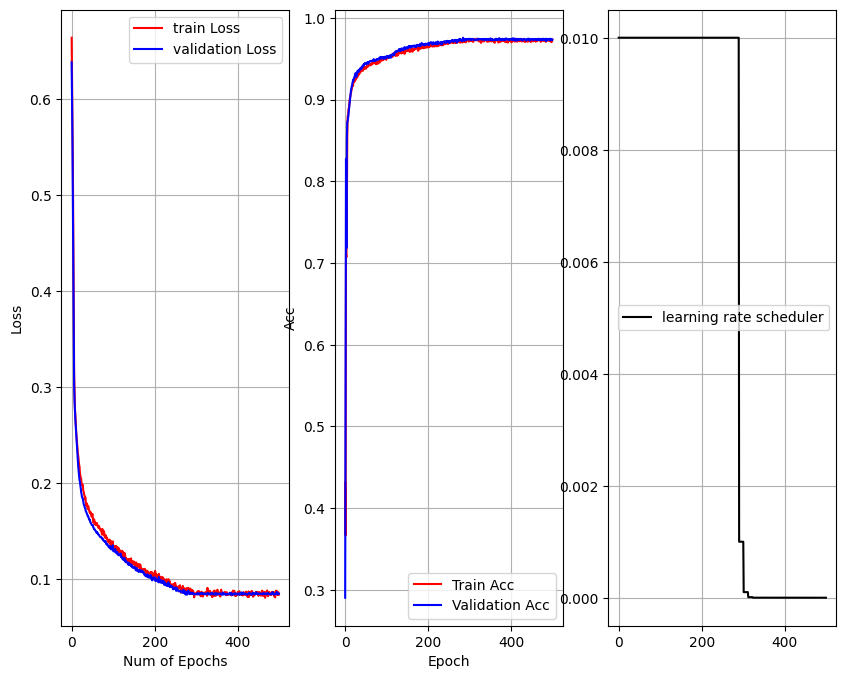

In [19]:
# Plot loss:
fig,ax = plt.subplots(1,3,figsize=(10,8))
ax[0].plot(range(num_epochs), loss_train_hist, color='red', label='train Loss')
ax[0].plot(range(num_epochs), loss_valid_hist, color='blue', label='validation Loss')
ax[0].set_xlabel('Num of Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(range(num_epochs), acc_train_hist, color='red', label='Train Acc')
ax[1].plot(range(num_epochs), acc_valid_hist, color='blue', label='Validation Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Acc')
ax[1].grid(True)
ax[1].legend()

ax[2].plot(range(num_epochs), lr_hist, color='black', label='learning rate scheduler')

ax[0].grid(True)
ax[0].legend()
ax[1].grid(True)
ax[1].legend()
ax[2].grid(True)
ax[2].legend()

# Analyze Final Accuracy on Test data:

In [22]:
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)
x,y = next(iter(test_loader))
x.shape,y.shape

(torch.Size([32, 12]), torch.Size([32]))

In [23]:
trained_model = torch.load(r'C:\Users\Asus\Desktop\Project\IOLAB19_DNN_Model.pt',weights_only=False)
model.to(device)
model.eval() 

Sequential(
  (0): Linear(in_features=12, out_features=150, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=150, out_features=100, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.25, inplace=False)
  (7): Linear(in_features=100, out_features=50, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.1, inplace=False)
  (10): Linear(in_features=50, out_features=25, bias=True)
  (11): ReLU()
  (12): Linear(in_features=25, out_features=1, bias=True)
)

In [24]:
acc_test = Accuracy(task='binary').to(device)
for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    yp = trained_model(x)
    acc_test(yp.squeeze(),y)
print(acc_test.compute())

tensor(0.9833, device='cuda:0')
